In [30]:
import os
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import spearmanr

In [31]:
PREDS_PATH = "/data/yosef3/scratch/ruchir/pgp_finetuning/1_pairwise/test_preds/"
GEUVADIS_COUNTS_PATH = "/data/yosef3/users/ruchir/pgp_finetuning/process_geuvadis_data/tpm/tpm_pca_annot.csv"
BASELINE_PREDS_PATH = (
    "/data/yosef3/users/ruchir/pgp_uq/data/model_perf/all_enformer_df.csv"
)
PREDIXCAN_PREDS_PATH = "predixcan.csv"

In [32]:
def load_geuvadis_data() -> pd.DataFrame:
    counts_df = pd.read_csv(GEUVADIS_COUNTS_PATH, index_col=0)
    counts_df = counts_df.reset_index().set_index("our_gene_name")
    return counts_df

In [33]:
def load_finetuned_preds() -> defaultdict[dict]:
    """
    Returns a dictionary of dictionaries, where the outer keys are the genes
    and the inner keys are the samples. The values are the predictions.
    """
    preds_by_gene = defaultdict(dict)
    data = np.load(os.path.join(PREDS_PATH, "test_preds.npz"))

    preds, genes, samples = data["preds"], data["genes"], data["samples"]
    for (pred, gene, sample) in zip(preds, genes, samples):
        preds_by_gene[gene][sample] = pred
    return preds_by_gene


def get_finetuned_corrs(finetuned_preds, geuvadis_df) -> dict[str, float]:
    corrs = {}
    for g in finetuned_preds:
        assert g in geuvadis_df.index
        samples = list(finetuned_preds[g].keys())
        gene_preds = [finetuned_preds[g][s] for s in samples]
        gene_counts = geuvadis_df.loc[g, samples].values
        corrs[g] = spearmanr(gene_preds, gene_counts)[0]
    return corrs


def compare_to_geuvadis_counts(finetuned_preds, geuvadis_df, gene, ax):
    samples = list(finetuned_preds[gene].keys())
    gene_preds = [finetuned_preds[gene][s] for s in samples]
    gene_counts = geuvadis_df.loc[gene, samples].values
    ax.scatter(gene_counts, gene_preds)
    ax.set(
        xlabel="Geuvadis counts",
        ylabel="finetuned predictions",
        title=f"Correlation: {spearmanr(gene_preds, gene_counts)[0]:.3f}",
    )


def compare_to_baseline_counts(finetuned_preds, baseline_df, gene, ax):
    samples = list(finetuned_preds[gene].keys())
    baseline_preds = baseline_df[gene][samples].values
    finetuned_preds = [finetuned_preds[gene][s] for s in samples]
    ax.scatter(baseline_preds, finetuned_preds)
    ax.set(
        xlabel="baseline predictions",
        ylabel="finetuned predictions",
        title=f"Correlation: {spearmanr(baseline_preds, finetuned_preds)[0]:.3f}",
    )

In [34]:
def load_other_model_preds_df(preds_df_path) -> pd.DataFrame:
    preds_df = pd.read_csv(preds_df_path, index_col=0)
    return preds_df


def get_other_model_corrs(preds_df, geuvadis_df, finetuned_preds) -> dict[str, float]:
    corrs = {}
    for g in finetuned_preds:
        assert g in preds_df.columns
        assert g in geuvadis_df.index
        samples = list(finetuned_preds[g].keys())

        gene_preds = preds_df[g][samples].values
        gene_counts = geuvadis_df.loc[g, samples].values
        corrs[g] = spearmanr(gene_preds, gene_counts)[0]
    return corrs

In [18]:
geuvadis_df = load_geuvadis_data()

In [19]:
finetuned_preds = load_finetuned_preds()
finetuned_corrs = get_finetuned_corrs(finetuned_preds, geuvadis_df)

In [20]:
baseline_df = load_other_model_preds_df(BASELINE_PREDS_PATH)
baseline_corrs = get_other_model_corrs(baseline_df, geuvadis_df, finetuned_preds)

predixcan_df = load_other_model_preds_df(PREDIXCAN_PREDS_PATH)
predixcan_corrs = get_other_model_corrs(predixcan_df, geuvadis_df, finetuned_preds)

In [42]:
def compare_finetuned_to_baseline_perf(
    finetuned_corrs,
    other_corrs,
    finetuned_preds,
    other_label,
    ax,
    abs_other: bool = False,
):
    genes = list(finetuned_corrs.keys())
    finetuned_corrs_l = [finetuned_corrs[g] for g in genes]
    other_corrs_l = [other_corrs[g] for g in genes]
    is_YRI_test_gene = [len(finetuned_preds[g]) < 421 for g in genes]

    df = pd.DataFrame(
        {
            "gene": genes,
            "finetuned Spearman": finetuned_corrs_l,
            "other Spearman": np.abs(other_corrs_l) if abs_other else other_corrs_l,
            "finetuned on non-YRI samples": is_YRI_test_gene,
        }
    )

    sns.scatterplot(
        data=df,
        x="other Spearman",
        y="finetuned Spearman",
        hue="finetuned on non-YRI samples",
        ax=ax,
    )
    ax.set_xlabel(
        f"|{other_label} Spearman|" if abs_other else f"{other_label} Spearman"
    )
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.set(aspect="equal", xlim=lims, ylim=lims)

    ax.axhline(
        df[df["finetuned on non-YRI samples"]]["finetuned Spearman"].mean(),
        color="orange",
        ls="--",
    )
    print(df[df["finetuned on non-YRI samples"]]["finetuned Spearman"].mean())
    print(df[df["finetuned on non-YRI samples"]]["other Spearman"].mean())

    ax.axvline(
        df[df["finetuned on non-YRI samples"]]["other Spearman"].mean(),
        color="orange",
        ls="--",
    )

    ax.axhline(
        df[~df["finetuned on non-YRI samples"]]["finetuned Spearman"].mean(),
        color="blue",
        ls="--",
    )
    ax.axvline(
        df[~df["finetuned on non-YRI samples"]]["other Spearman"].mean(),
        color="blue",
        ls="--",
    )

    return df

0.45994055283892443
0.1797831060193094
0.45994055283892443
0.49432942207702774


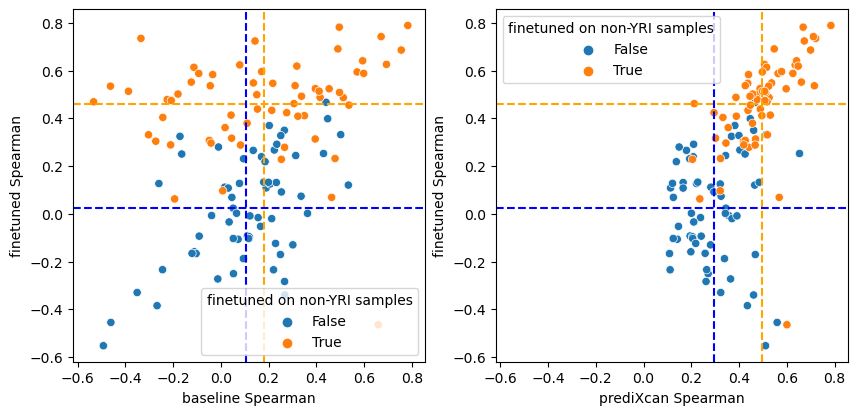

In [43]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
_ = compare_finetuned_to_baseline_perf(
    finetuned_corrs, baseline_corrs, finetuned_preds, "baseline", axs[0]
)
_ = compare_finetuned_to_baseline_perf(
    finetuned_corrs, predixcan_corrs, finetuned_preds, "prediXcan", axs[1]
)
plt.show()

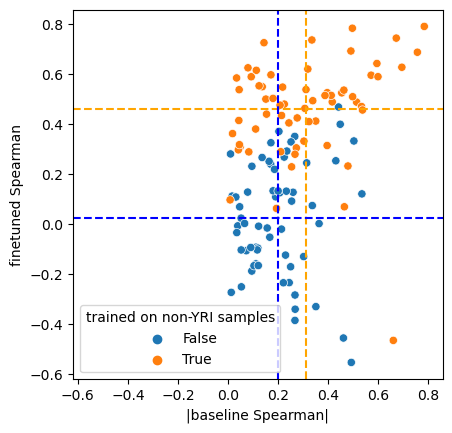

In [21]:
_ = compare_finetuned_to_baseline_perf(
    finetuned_corrs, baseline_corrs, finetuned_preds, abs_baseline=True
)